# Quantum Information Lab 2

## Luca Manzi 856095

The task of our project is to develop a circuit that has a quantum register and a "black box" that applies a CNOT to any random subset of the register, those CNOTs will be controlled by a qubit of the register and will target an ancilla qubit.

- The first naive classical approach, that will have complexity of $O(n)$, where $n$ is the number of qubits in the register, will try each of the qubits and chack if they are connected to the ancilla.

- The second approach will exploit quantum properties and phase kickback, with a constant complexity $O(1)$


In [171]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.visualization import plot_histogram
import itertools

from qiskit_aer import AerSimulator
import numpy as np

simulator = AerSimulator()

DEBUG = True

In [172]:
# black box definition
n = 4
def blackBox(n) -> list:
    # save the indices:
    indices = []
    for i in range(n):
        random = np.random.randint(2)
        if random == 1:
            indices.append(i)
    return indices
blackBox(n)

[1]

In [173]:
# create a simple function that gives us the basis for exploring 
# the whole classical input space, to get classical result
def encode (qc, qubits, bits):
    for i in range(len(qubits)):
        if bits[i] == 1:
            qc.x(qubits[i])

basis = [((n+1)*[0]) for i in range(n)] # init all basis for qubits
for i in range(len(basis)):
    basis[i][i] = 1

[print(b) for b in basis]
basis


[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]


[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]]

In [175]:
black_box =  blackBox(n) # creating of the black box indices

if DEBUG:
    black_box = [0,1,3] # example if we need to keep it fixed

for i in black_box: # test black Box creator, we will use this
    print(i)

0
1
3


CNOT set on qubit at index: 0
CNOT set on qubit at index: 1
CNOT set on qubit at index: 3
Basis used for this iteration: [1, 0, 0, 0, 0]


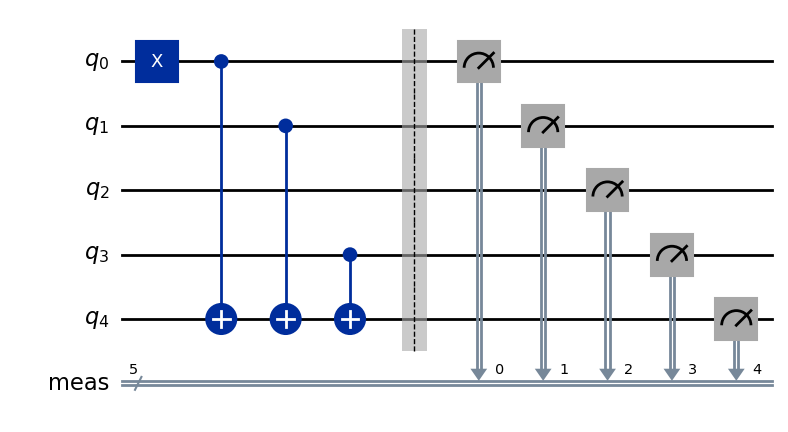

In [176]:
# this is an example of one circuit that we will create later
qc = QuantumCircuit(n+1)

[print(f"CNOT set on qubit at index: {i}") for i in black_box] # print black box

if len(black_box) == 0: # if no CNOT are set, say it to the user
    print("No CNOT are set")

current_basis = [1,0,0,0,0]
print(f"Basis used for this iteration: {current_basis}")

encode(qc, range(n+1), current_basis) # encode a basis in the circuit

for i in black_box: # apply CNOTs
    qc.cx(i,n)

qc.measure_all() # measure
qc.draw('mpl') # print the circuit

## Classical approach


In [177]:
print("On the black box we set: \n")

[print(f"CNOT set on qubit at index: {i}") for i in black_box] # print black box

if len(black_box) == 0: # if no CNOT are set, say it to the user
    print("No CNOT are set")

print("\nLoop and test each of the qubits: \n")

for i,b in enumerate(basis): # for each basis)
    qc = QuantumCircuit(n+1) # create a circuit, last qubit is the ancilla
    encode(qc, range(n+1), b)
    
    for j in black_box: # apply CNOTs
        qc.cx(j,n)


    qc.measure_all()
    transpile(qc, simulator) 
    result = simulator.run(qc).result().get_counts()
    #print(result)
    state = (list(result.keys())[0])
    ancilla = state[0]
    if ancilla == '1':
        print("CNOT revealed on position", i)
    #print(b, state)

On the black box we set: 

CNOT set on qubit at index: 0
CNOT set on qubit at index: 1
CNOT set on qubit at index: 3

Loop and test each of the qubits: 

CNOT revealed on position 0
CNOT revealed on position 1
CNOT revealed on position 3


## Quantum approach: Phase Kickback

- The idea is to use $$| + + + ... - \rangle$$ 
- So we encode: 
    - the qubits to be $$|0 \rangle\otimes|0\rangle \otimes \dots \otimes |0\rangle $$ 
    - the ancilla to $$|1\rangle$$
- apply a Walsh Hadamard to the circuit to obtain the desired state


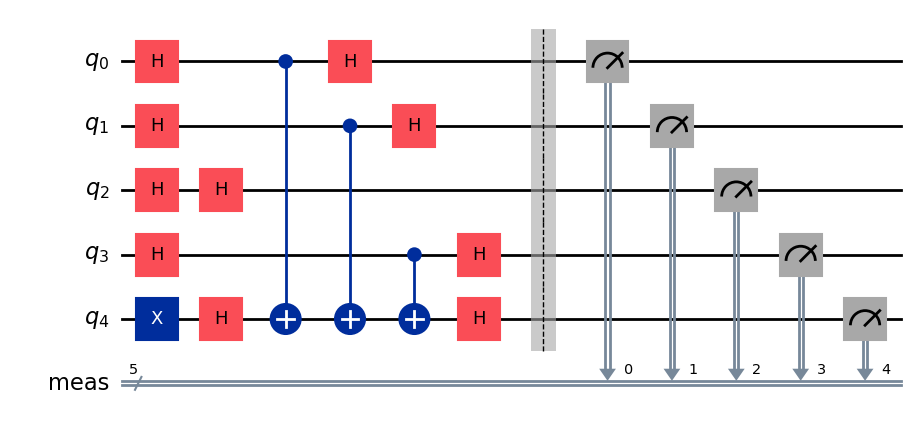

In [178]:
qc = QuantumCircuit(n+1)

qc.x([n]) # ancilla to |1>

qc.h(range(n+1)) # Walsh Hadamard

for j in black_box: # apply CNOTs
    qc.cx(j,n)

qc.h(range(n+1)) # Go back to Computational Basis

qc.measure_all()
transpile(qc, simulator) 
result = simulator.run(qc).result().get_counts()
qc.draw('mpl')

In [179]:
for i in (np.where(
    np.array([int(j)
              for j in list(result.keys())[0][::-1][:-1]]) == 1)[0]):
        print(f"CNOT revealed in postion {i}")

CNOT revealed in postion 0
CNOT revealed in postion 1
CNOT revealed in postion 3


## Insight, smart transpiler

Using a separate measurement show us how the circuit is simplified by the transpiler:
- If a qubit doesn't subdue a CNOT, the transpiler simplifies the double Hadamard since it is self adjoint
- We don't need to measure the ancilla, since it will be constant.

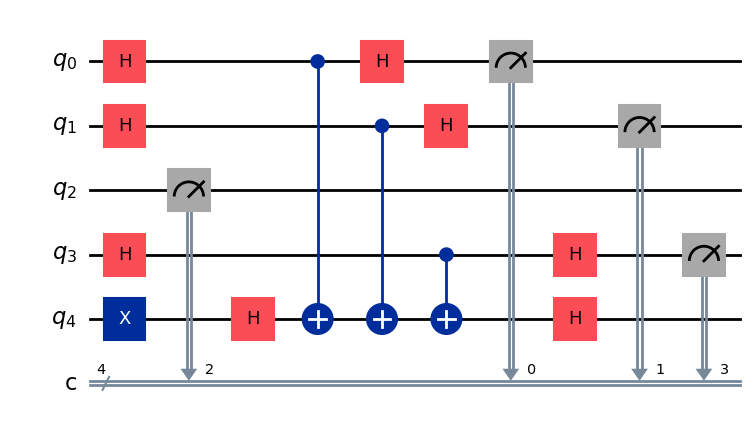

In [180]:
# Create a Quantum Circuit with n+1 qubits and n classical bits
qc = QuantumCircuit(n+1, n)

qc.x(n)  # Ancilla to |1⟩
qc.h(range(n+1)) # Walsh Hadamard

for j in black_box:
    qc.cx(j, n)

qc.h(range(n+1))

# measure each qubit independently
for i in range(n):
    qc.measure(i, i)  # Map each qubit to corresponding classical bit

qc = transpile(qc, simulator)
result = simulator.run(qc).result().get_counts()

qc.draw('mpl')


In [181]:
state = list(result.keys())[0][::-1] # reverse the order of the bits

bit_array = np.array([int(bit) for bit in state])  

for i in np.where(bit_array == 1)[0]:
    print(f"CNOT revealed in position {i}")

CNOT revealed in position 0
CNOT revealed in position 1
CNOT revealed in position 3
